In [1]:
import itertools
import math
import time
import numpy as np
import matplotlib.pyplot as plt
from pyspark.sql import Row
from pyspark.sql import SparkSession
from pyspark.ml.linalg import SparseVector
from pyspark.mllib.linalg import DenseVector
from pyspark.ml.classification import LogisticRegression

In [2]:
# create spark session
app_name = "final_notebook"
master = "local[*]"
spark = SparkSession\
        .builder\
        .appName(app_name)\
        .master(master)\
        .getOrCreate()
sc = spark.sparkContext

In [2]:
spark

In [3]:
sc = spark.sparkContext

## Factorization machines using gradient descent

#### The home grown factorization machine model was run on a small toy training set of around 4000 records and tested on a dataset of around 400 records.

In [3]:
# initialize learning rate, number of latent factors, mean, standard deviation
learning_rate = 0.01
num_latent_factors = 100
# used for initializing the factorized parameters for interactions
mean = 0
# used for initializing the factorized parameters for interactions
std = 0.01

In [4]:
# initializing the regularization parameters
# techincally these should come from cross validation
reg_bias = 0.01
reg_independent = 0.01
reg_interaction = np.full(num_latent_factors, 0.01)

In [5]:
def prediction_calculation(features, w0, W, V):
    """Performs class prediction calculations for the given set of features and weights"""
    # dot product of independent features and weights
    # appending the bias term as well
    independent_features = np.append([1.0], features)
    independent_weights = np.append([w0], W)
    
    # get combinations of features for the interaction terms with degree 2
    total_interaction = 0.0
    for subset in itertools.combinations(enumerate(features),2):
        index1 = int(subset[0][0])
        index2 = int(subset[1][0])
        feature1 = float(subset[0][1])
        feature2 = float(subset[1][1])
        # dot product of v parameters and features
        total_interaction += np.dot(V[index1],V[index2]) * feature1 * feature2
    product = np.dot(independent_features,independent_weights) + total_interaction
    h_x = 1.0/(1.0+math.exp(-product))
    return h_x

In [6]:
def get_parameter_gradients(data, w0, W, V, num_features, num_latent_factors):
    """Yields gradients for all the model parameters"""
    y = data['label']
    features_vec = data['features']
    features, W, V = get_params_features_for_vectors(features_vec, W, V)
    h_x = prediction_calculation(features, w0, W, V)
    # converting the features vector representation to array to get the entire representation
    features_array = features_vec.toArray()
    
    # calculating w0 gradients
    w0_gradient = h_x - y
    yield ('w0', [w0_gradient])
    
    # calculating W gradients
    W_gradient = w0_gradient*features_array
    yield ('W', [W_gradient])
    
    # calculating V gradients
    # calculating the sum part of the differenciation of interaction parameters(xl*sum(vj,f * xj))
    sum_v_features = np.zeros((num_features,num_latent_factors))
    # executing sum(vj,f * xj) where j!= l (for all j features except l) in the expression xl*sum(vj,f * xj)
    for i, feature in enumerate(features_array):
        # if the feature is zero no need to compute the sum, we will have a vector of zeros for it
        if feature != 0:
            # handle the first and last elements
            if i == 0:
                sum_v_features[i] = np.dot(features[i+1:],V[i+1:,:])
                continue
            if i == num_features-1:
                sum_v_features[i] = np.dot(features[:i],V[:i,:])
                continue
            sum_v_features[i] = np.dot(np.concatenate((features[:i], features[i+1:])),np.concatenate((V[:i,:], V[i+1:,:])))
    # reshape the feature vector to be able to multiple each feature with it's sum of (vj,f*xj) to compute the expression
    # xl*sum(vj,f * xj) where j!= l (for all j features except l)
    feature_reshape = np.reshape(features_array, (num_features, 1))
    # now multiply to get the entire V at once
    differenciation_interaction = np.multiply(feature_reshape,sum_v_features)
    V_gradient = w0_gradient*differenciation_interaction
    yield ('V', [V_gradient])

In [7]:
def get_log_sigmoid(data, w0, W, V):
    """Calculate the log of the prediction, used for calculating the loss"""
    y = data['label']
    features, W, V = get_params_features_for_vectors(data['features'], W, V)
    h_x = prediction_calculation(features, w0, W, V)
    
    if int(y) == 1:
        yield -np.log(h_x)
    else:
        yield -np.log(1-h_x)

In [8]:
def get_log_loss(data_rdd, w0, W, V):
    """Calculating the log loss"""
    loss = data_rdd.flatMap(lambda data: get_log_sigmoid(data, w0, W, V))\
                   .mean()
    
    return loss

In [9]:
def get_params_features_for_vectors(features, W, V):
    """Handle the SparseVectors, DenseVectors or arrays of parameters and features to return the actual values to be used in the gradient calculations"""
    # unpacking the sparse vector to get the respective weights for the features and using just the values present
    if type(features) == SparseVector:
        W_vec = W[features.indices]
        V_vec = V[features.indices]
        features_vec = features.values
    else:
        W_vec = W
        V_vec = V
        features_vec = features

    return features_vec, W_vec, V_vec

In [15]:
def fm_gd(train_rdd, validation_rdd, learning_rate, num_latent_factors, mean, std, reg_bias, reg_independent, reg_interaction, num_steps):    
    """Factorization machine model using gradient descent"""
    
    num_features = train_rdd.take(1)[0]['features'].size 
    print('num_features:',num_features)
    
    # initialize the model parameters
    w0 = 0.0
    W = np.zeros(num_features)
    V = np.random.normal(mean, std, (num_features,num_latent_factors))
    
    num_features_b = sc.broadcast(num_features)
    num_latent_factors_b = sc.broadcast(num_latent_factors)
    
    # initialize lists to track model performance
    train_history, validation_history = [], []
    
    for i in range(num_steps):
        # broadcast the model parameters
        w0_b = sc.broadcast(w0)
        W_b = sc.broadcast(W)
        V_b = sc.broadcast(V)

        # calculate all gradients for w0, W and V
        all_gradients_rdd = train_rdd.flatMap(lambda x: get_parameter_gradients(x, w0_b.value, W_b.value, V_b.value, num_features_b.value, num_latent_factors_b.value))\
                                     .cache()
        # perform w0 updates
        w0_gradient = all_gradients_rdd.filter(lambda x: x[0] == 'w0')\
                                       .flatMap(lambda x: x[1])\
                                       .mean()
        w0 -= learning_rate * (w0_gradient + 2 * reg_bias * w0)
        
        # perform W updates
        W_gradient = all_gradients_rdd.filter(lambda x: x[0] == 'W')\
                                       .flatMap(lambda x: x[1])\
                                       .mean()
        W -= learning_rate * (W_gradient + 2 * reg_independent * W)
        
        # perform V updates
        V_gradient = all_gradients_rdd.filter(lambda x: x[0] == 'V')\
                                       .flatMap(lambda x: x[1])\
                                       .mean()
        V -= learning_rate * (V_gradient + 2 * np.multiply(reg_interaction, V))
        
        # find train and validation loss at each iteration
#         training_loss = get_log_loss(train_rdd, w0, W, V)
#         validation_loss = get_log_loss(validation_rdd, w0, W, V)
        
#         # keep track of validation/train loss for plotting
#         train_history.append(training_loss)
#         validation_history.append(validation_loss)
        
        
    return w0, W, V, train_history, validation_history


In [11]:
# train set
train_df = spark.read.parquet('gs://w261_desa2/notebooks/data/toySampleTrain.parquet')

In [12]:
# train, validation split set
train_df, validation_df = train_df.randomSplit([.9, .1], 10)
train_df = train_df.cache()
validation_df = validation_df.cache()

In [13]:
# create rdd from df
train_rdd = train_df.rdd.cache()
validation_rdd = validation_df.rdd.cache()

In [113]:
start = time.time()
w0, W, V, train_loss, validation_loss = fm_gd(train_rdd, validation_rdd, learning_rate, num_latent_factors, mean, std, reg_bias, reg_independent, reg_interaction, 10)
print(f'... completed job in {time.time() - start} seconds.')

num_features: 24086
... completed job in 2766.5750439167023 seconds.


In [16]:
# predict
def predict_classes(data, w0, W, V):
    features_vec = data['features']
    features, W, V = get_params_features_for_vectors(features_vec, W, V)
    h_x = prediction_calculation(features, w0, W, V)
    if h_x >= 0.5:
        if int(data['label']) == 1:
            yield ('correct', 1)
        else:
            yield ('wrong', 1)
    else:
        if int(data['label']) == 0:
            yield ('correct', 1)
        else:
            yield ('wrong', 1)

In [4]:
# test set
test_df = spark.read.parquet('gs://w261_desa2/notebooks/data/toySampleTest.parquet')
test_rdd = test_df.rdd.cache()

In [108]:
# get the predicted classes for the test set
result = test_rdd.flatMap(lambda x: predict_classes(x, w0, W, V)).reduceByKey(lambda x,y: x + y).collect()

In [116]:
result

[('correct', 301), ('wrong', 126)]

In [119]:
accuracy = result[0][1]/(result[1][1]+result[0][1])
accuracy

0.7049180327868853

In [26]:
# plot error curves
def plotErrorCurves(trainLoss, testLoss, title = None):
    """
    Helper function for plotting.
    Args: trainLoss (list of log loss) , testLoss (list of log loss)
    """
    fig, ax = plt.subplots(1,1,figsize = (16,8))
    x = list(range(len(trainLoss)))[1:]
    ax.plot(x, trainLoss[1:], 'k--', label='Training Loss')
    ax.plot(x, testLoss[1:], 'r--', label='Test Loss')
    ax.legend(loc='upper right', fontsize='x-large')
    plt.xlabel('Number of Iterations')
    plt.ylabel('Log Loss error')
    if title:
        plt.title(title)
    plt.show()

#### Following is a plot of training and validation loss during training on a small dataset of 849 records over 30 iterations

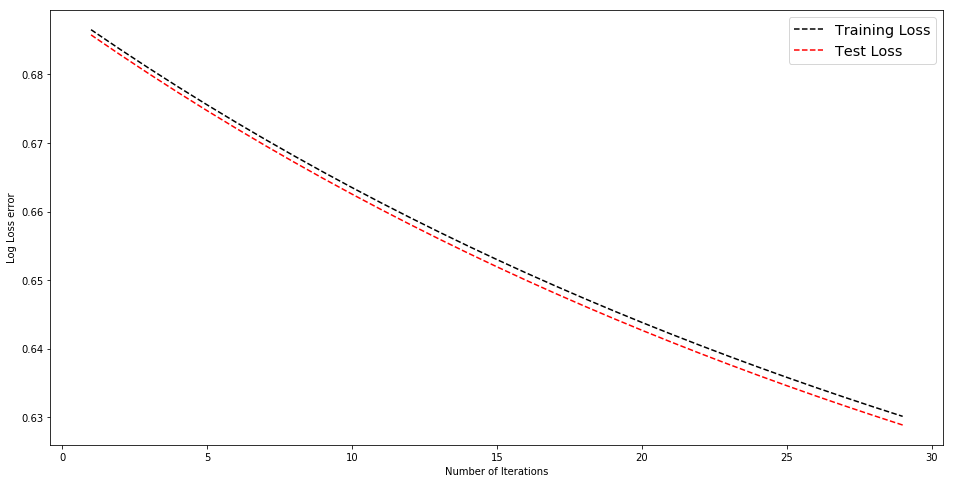

In [24]:
plotErrorCurves(train_loss, validation_loss)

## Logistic Regression with just independent variables

In [35]:
def prediction_calculation_independent(features, w0, W):
    """Performs class prediction calculations for the given set of features and weights"""
    # dot product of independent features and weights
    # appending the bias term as well
    independent_features = np.append([1.0], features)
    independent_weights = np.append([w0], W)
    
    product = np.dot(independent_features,independent_weights)
    h_x = 1.0/(1.0+math.exp(-product))
    return h_x

In [36]:
def get_parameter_gradients_independent(data, w0, W):
    """Yields gradients for all the model parameters"""
    y = data['label']
    features_vec = data['features']
    features, W_condensed = get_params_features_for_vectors_independent(features_vec, W)
    h_x = prediction_calculation_independent(features, w0, W_condensed)
    # converting the features vector representation to array to get the entire representation
    features_array = features_vec.toArray()
    augmented_features = np.append([1.0], features_array)
    
    # calculating W gradients
    gradients = (h_x - y)*augmented_features
    yield gradients

In [37]:
def get_log_loss_independent(data_rdd, w0, W):
    """Calculating the log loss"""
    # calculation the log loss
    loss = data_rdd.flatMap(lambda data: get_log_sigmoid_independent(data, w0, W))\
                   .mean()
    
    return loss

In [38]:
def get_log_sigmoid_independent(data, w0, W):
    """Calculate the log of the prediction, used for calculating the loss"""
    y = data['label']
    h_x = prediction_calculation_independent(data['features'], w0, W)
   
    if int(y) == 1:
        yield -np.log(h_x)
    else:
        yield -np.log(1-h_x)

In [39]:
def get_params_features_for_vectors_independent(features, W):
    """Handle the SparseVectors, DenseVectors or arrays of parameters and features to return the actual values to be used in the gradient calculations"""
    # unpacking the sparse vector to get the respective weights for the features and using just the values present
    if type(features) == SparseVector:
        W_vec = W[features.indices]
        features_vec = features.values
    else:
        W_vec = W
        features_vec = features

    return features_vec, W_vec

In [41]:
def logistic_gd(train_rdd, validation_rdd, learning_rate=0.1, reg_type='ridge', reg_param=0.01, num_steps=20):    
    """Logistic regression model using gradient descent"""
    
    num_features = train_rdd.take(1)[0]['features'].size 
    print('num_features:',num_features)
    
    # initialize the model parameters
    w0 = 0.0
    W = np.zeros(num_features)
    
    # initialize lists to track model performance
    train_history, validation_history = [], []
    
    for i in range(num_steps):
        # broadcast the model parameters
        w0_b = sc.broadcast(w0)
        W_b = sc.broadcast(W)

        # calculate all gradients for w0, W and V
        gradients = train_rdd.flatMap(lambda x: get_parameter_gradients_independent(x,w0_b.value,W_b.value))\
                             .mean()
        
        if reg_type == 'ridge':
             gradient_penalty = gradients[1:] + 2 * reg_param * W
        if reg_type == 'lasso':
             gradient_penalty = gradients[1:] + reg_param * np.sign(W)

        w0 = w0 - learning_rate * gradients[0]
        if reg_type == 'ridge' or reg_type == 'lasso':
            W = W - learning_rate * gradient_penalty
        else:
            W = W - learning_rate * gradients[1:]
        
        # find train and validation loss at each iteration
        training_loss = get_log_loss_independent(train_rdd, w0, W)
        validation_loss = get_log_loss_independent(validation_rdd, w0, W)
        
        # keep track of validation/train loss for plotting
        train_history.append(training_loss)
        validation_history.append(validation_loss)
        
        
    return w0, W, train_history, validation_history


In [42]:
# train set
train_df = spark.read.parquet('dac/toy/toySampleTrain.parquet')
train_df, train_small_df, validation_df = train_df.randomSplit([.7, .2, .1], 10)
train_df = train_df.cache()
train_small_df = train_small_df.cache()
validation_df = validation_df.cache()

In [43]:
# create rdd from df
train_rdd = train_df.rdd.cache()
train_small_rdd = train_small_df.rdd.cache()
validation_rdd = validation_df.rdd.cache()

In [44]:
start = time.time()
w0_l, W_l, train_loss_l, validation_loss_l = logistic_gd(train_small_rdd, validation_rdd, num_steps=5)
print(f'... completed job in {time.time() - start} seconds.')

num_features: 24086
... completed job in 4.83094048500061 seconds.


In [51]:
# predict
def predict_classes_independent(data, w0, W):
    features_vec = data['features']
    features, W_condensed = get_params_features_for_vectors_independent(features_vec, W)
    h_x = prediction_calculation_independent(features, w0, W_condensed)
    
    if h_x >= 0.5:
        if int(data['label']) == 1:
            yield ('correct', 1)
        else:
            yield ('wrong', 1)
    else:
        if int(data['label']) == 0:
            yield ('correct', 1)
        else:
            yield ('wrong', 1)

In [52]:
# test set
test_df = spark.read.parquet('dac/toy/toySampleTest.parquet')
test_rdd = test_df.rdd.cache()

In [53]:
# get the predicted classes for the test set
result = test_rdd.flatMap(lambda x: predict_classes_independent(x, w0_l, W_l)).reduceByKey(lambda x,y: x + y).collect()

In [54]:
result

[('wrong', 126), ('correct', 301)]

In [55]:
accuracy = result[1][1]/(result[1][1]+result[0][1])
accuracy

0.7049180327868853

#### Following is a plot of training and validation loss during training on a small dataset of 826 records over 5 iterations 

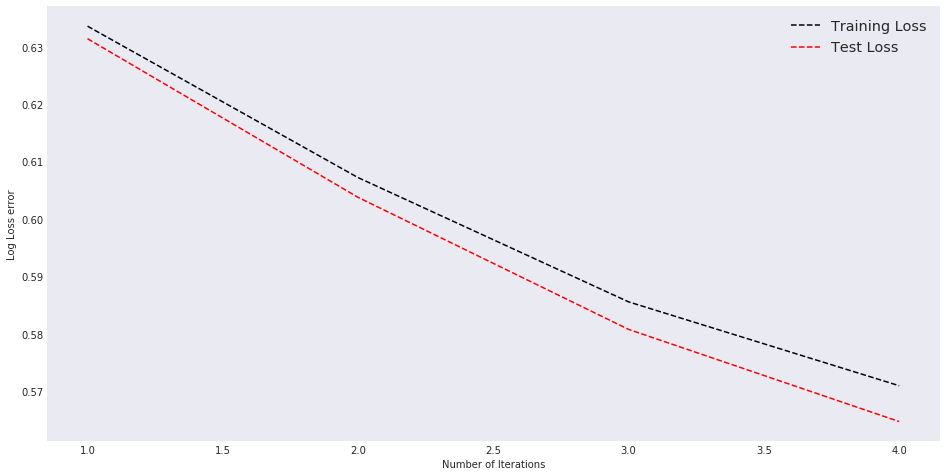

In [27]:
plotErrorCurves(train_loss_l, validation_loss_l)